In [39]:
# We look at our data...
from skimage.io import imread
import matplotlib.pyplot as plt
import pandas as pd
import os

def begin():
    os.chdir('D:\\SideProject\\Pnue-mondium\\chest_xray\\test')
    for files in os.listdir(os.getcwd()):
        print(files)
    
    # There are three directories...
    # Train...
    # Test...
    # Val...

    # What is the distribution of those with Pneumonia and those without?
    file_paths = []
    normal_count = 0
    for files in os.listdir('NORMAL'):
        normal_count += 1
        file_paths.append(os.getcwd() + "\\NORMAL\\" + files)
    pneumonia_count = 0    
    for files in os.listdir('PNEUMONIA'):
        pneumonia_count += 1
        file_paths.append(os.getcwd() + "\\PNEUMONIA\\" + files)
    total = normal_count + pneumonia_count
    print('Number Normal: {}'.format(normal_count))
    print('Percent Normal: {}%'.format(round((normal_count / total) * 100, 2)))
    print('Number Pneumonia: {}'.format(pneumonia_count))
    print('Percent Pneumonia: {}%'.format(round((pneumonia_count / total) * 100, 2)))
    print('Total: {}'.format(total))

    df = pd.DataFrame(file_paths, columns = ['Path'])
    df['Label'] = df['Path'].apply(lambda x: 1 if 'PNEUMONIA' in x else 0)
    return df

df = begin()

NORMAL
PNEUMONIA
Number Normal: 234
Percent Normal: 37.5%
Number Pneumonia: 390
Percent Pneumonia: 62.5%
Total: 624


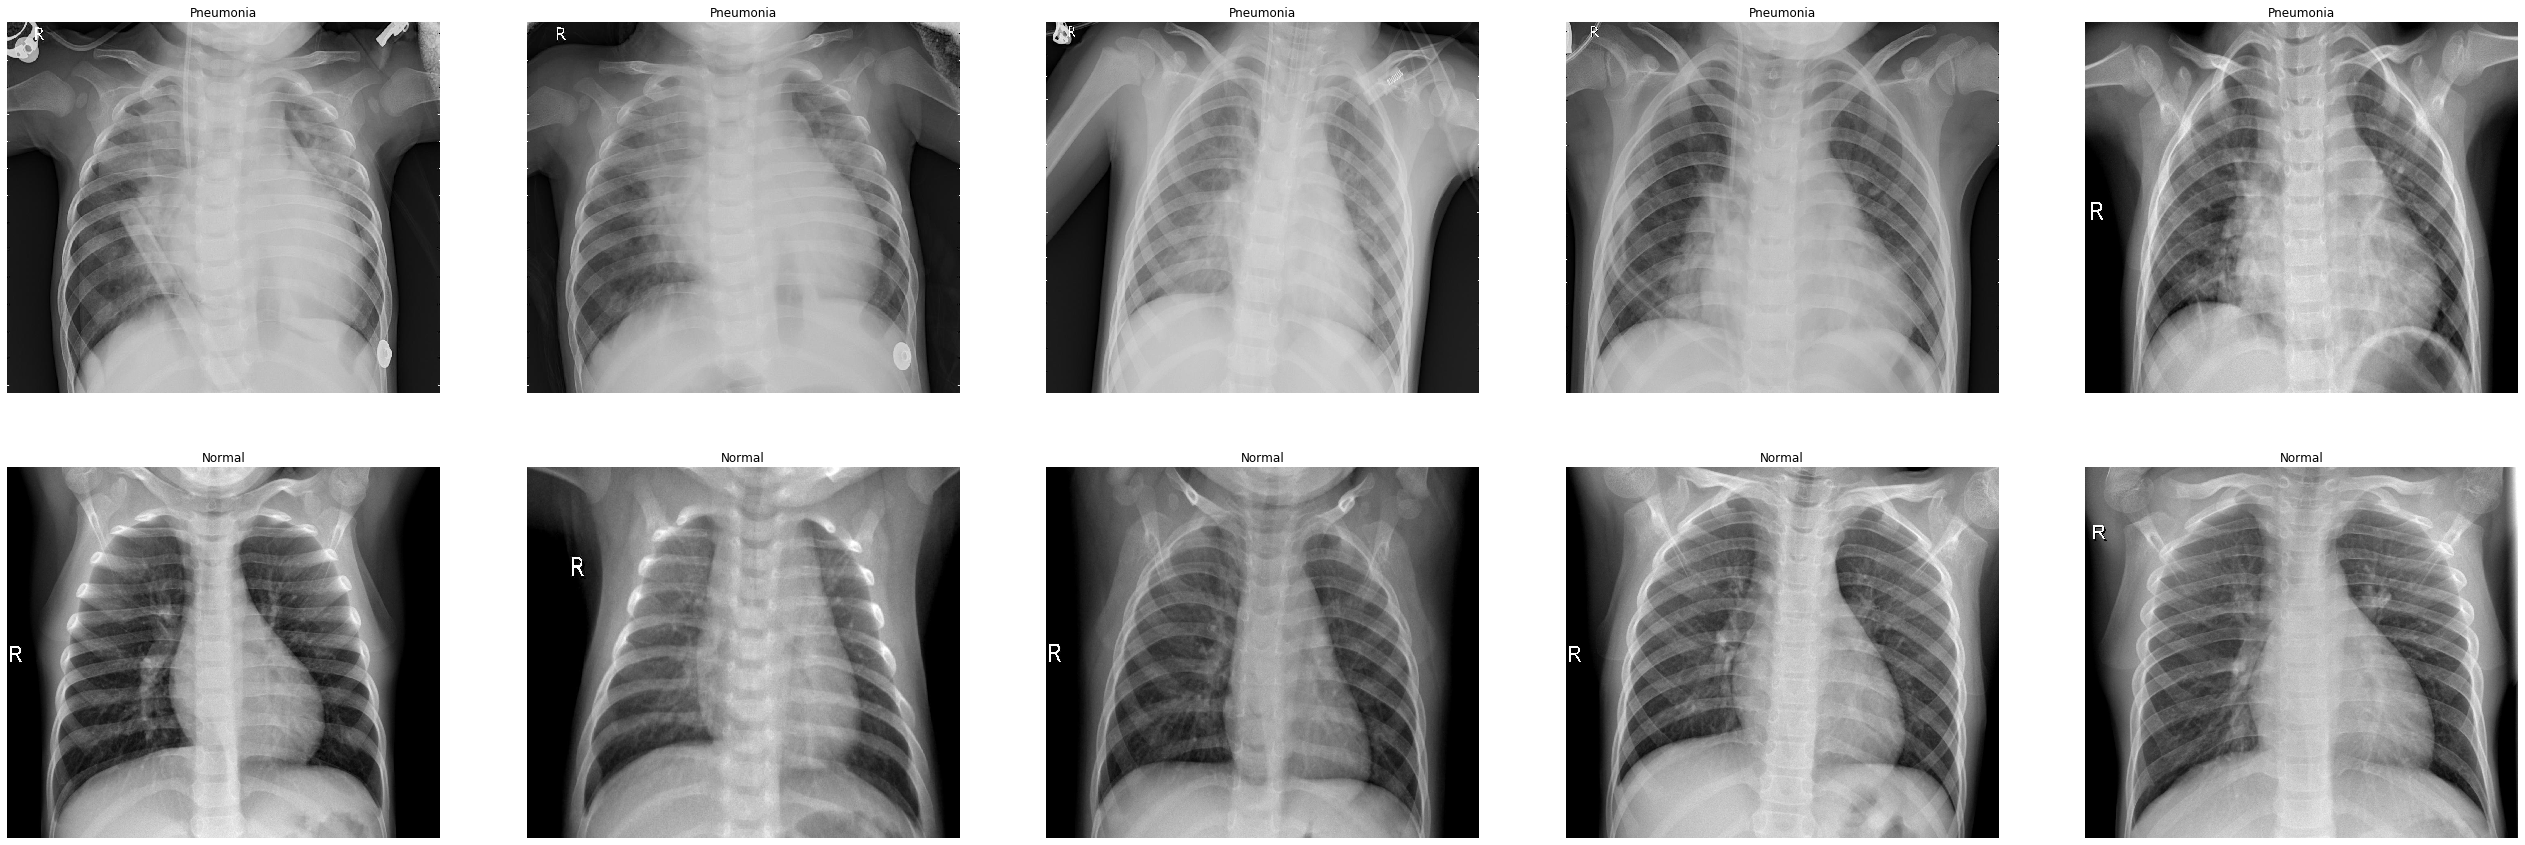

In [40]:
# So, the dataset is imbalanced... a large amount of those with Pneumonia as opposed to those that do not.
# Therefore, we anticipate that a model (out of the box) would have preference towards predictions with Pneumonia.
# Let's see a few images to see the difference between a Pneumonia and Normal case...
def display_images(df):
    test_images = df[df['Label'] == 1].tail()['Path'].to_list()
    test_images += df[df['Label'] == 0].tail()['Path'].to_list()

    f, ax = plt.subplots(2, 5, figsize=(45,15))
    for index, image_ in enumerate(test_images):
        image = imread(image_)
        ax[index//5, index%5].imshow(image, cmap = 'gray')
        if index < 5:    ax[index//5, index%5].set_title("Pneumonia")
        else:    ax[index//5, index%5].set_title("Normal")
        ax[index//5, index%5].axis('off')
        ax[index//5, index%5].set_aspect('auto')
display_images(df)

In [41]:
# It is really tough to see (with the human eye) noticeable differences between the two classes...
# As Pnuemonia is an infection where fluid fills the lung air sacs, we expect the images with Pneumonia
# to have more white/gray hue then the images that do not have Pneumonia.
# We seek to "crop" each image such that only the lungs will be visible for Grayscale processing.
# From here, we determine if the average grayscale values are different between the two classes.

def crop_images(df, type_ = "training"):
    from PIL import Image as image
    formatted_images = []
    for path, label in list(zip(df['Path'].to_list(), df['Label'].to_list())):
        im = image.open(path)
        width, length= im.size
        if width < 800 and length < 1000:
            cropped_img = im.crop((30, 0, width-30, length))
            formatted_images.append((cropped_img, label))
        elif width >= 800  and length < 1000:
            cropped_img = im.crop((100, 200, width - 100, length))
            formatted_images.append((cropped_img, label))        
        elif length < 1500 and width < 1500:
            cropped_img = im.crop((150, 250, width - 150, length))
            formatted_images.append((cropped_img, label))
        else:
            cropped_img = im.crop((150, 300, width - 150, length))
            formatted_images.append((cropped_img, label))     
    
    # At this point, we save the images in a directory for processing...
    if type_ == 'training': # We save the training cropped images...
        import os
        current_dir = os.getcwd()
        print(current_dir)
        if "formatted_{}_normal".format(type_) not in os.listdir(current_dir):
            os.mkdir('formatted_{}_normal'.format(type_))
            os.mkdir('formatted_{}_pnuemonia'.format(type_))
            n = 0
            for content, label in formatted_images:
                # We save the cropped images...
                if label == 1:
                    content.save(current_dir + '\\formatted_{}_pnuemonia\\file_{}.jpeg'.format(type_, n))
                else:
                    content.save(current_dir + '\\formatted_{}_normal\\file_{}.jpeg'.format(type_, n))
                n += 1
                
    if type_ == 'val': # We save the validation cropped images...
        import os
        current_dir = os.getcwd()
        print(current_dir)
        if "formatted_{}_normal".format(type_) not in os.listdir(current_dir):
            os.mkdir('formatted_{}_normal'.format(type_))
            os.mkdir('formatted_{}_pnuemonia'.format(type_))
            n = 0
            for content, label in formatted_images:
                # We save the cropped images...
                if label == 1:
                    content.save(current_dir + '\\formatted_{}_pnuemonia\\file_{}.jpeg'.format(type_, n))
                else:
                    content.save(current_dir + '\\formatted_{}_normal\\file_{}.jpeg'.format(type_, n))
                n += 1    
                
    if type_ == 'test': # We save the testing cropped images...
        import os
        current_dir = os.getcwd()
        print(current_dir)
        if "formatted_{}_normal".format(type_) not in os.listdir(current_dir):
            os.mkdir('formatted_{}_normal'.format(type_))
            os.mkdir('formatted_{}_pnuemonia'.format(type_))
            n = 0
            for content, label in formatted_images:
                # We save the cropped images...
                if label == 1:
                    content.save(current_dir + '\\formatted_{}_pnuemonia\\file_{}.jpeg'.format(type_, n))
                else:
                    content.save(current_dir + '\\formatted_{}_normal\\file_{}.jpeg'.format(type_, n))
                n += 1                    
                    

crop_images(df, 'test')

D:\SideProject\Pnue-mondium\chest_xray\test


In [109]:
# Visual of distribution of Image Dimensions...
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(x=[width[0] for width in dimensions], y=[height[1] for height in dimensions], mode='markers'))
fig.update_layout(title_text = 'Image Dimension Distribution',
        xaxis_title_text = 'Width',
        yaxis_title_text = 'Height')
fig.show()

In [5]:
# At this point, we convert the images to grayscale and compute the average grayscale value of the image...
import numpy as np
df_ = pd.DataFrame(list(zip([im[0] for im in formatted_images], [label[1] for label in formatted_images], df['Path'].to_list())), columns = ['Image', 'Label', 'Path'])
df_['Grayscale'] = df_['Image'].apply(lambda x: np.array(x.convert('LA')).mean())
df_

,Image,Label,Path,Grayscale
0,<PIL.Image.Image image mode=L size=1790x1558 a...,0,D:\SideProject\Pnue-mondium\chest_xray\train\N...,201.952881
1,<PIL.Image.Image image mode=L size=1122x902 at...,0,D:\SideProject\Pnue-mondium\chest_xray\train\N...,189.716575
2,<PIL.Image.Image image mode=L size=1510x1134 a...,0,D:\SideProject\Pnue-mondium\chest_xray\train\N...,200.591219
3,<PIL.Image.Image image mode=L size=1318x979 at...,0,D:\SideProject\Pnue-mondium\chest_xray\train\N...,205.948441
4,<PIL.Image.Image image mode=L size=1300x825 at...,0,D:\SideProject\Pnue-mondium\chest_xray\train\N...,194.411133
...,...,...,...,...
5211,<PIL.Image.Image image mode=L size=1214x682 at...,1,D:\SideProject\Pnue-mondium\chest_xray\train\P...,194.949793
5212,<PIL.Image.Image image mode=L size=1056x496 at...,1,D:\SideProject\Pnue-mondium\chest_xray\train\P...,204.256375
5213,<PIL.Image.Image image mode=L size=952x656 at ...,1,D:\SideProject\Pnue-mondium\chest_xray\train\P...,200.762671
5214,<PIL.Image.Image image mode=L size=1048x528 at...,1,D:\SideProject\Pnue-mondium\chest_xray\train\P...,207.633772


In [91]:
# Let's see what the distribution value's are...
print(df_[df_['Label'] == 0]['Grayscale'].describe()) ### Normal
print('\n')
print(df_[df_['Label'] == 1]['Grayscale'].describe()) ### Pneumonia
# It appears the two classes are similar in Grayscale value...

count    1341.000000
mean      198.546146
std         6.842681
min       173.228161
25%       194.213910
50%       198.581395
75%       202.869342
max       225.699290
Name: Grayscale, dtype: float64


count    3875.000000
mean      199.112929
std        10.546511
min       160.406508
25%       192.782996
50%       199.710294
75%       206.298164
max       238.926284
Name: Grayscale, dtype: float64


In [81]:
# Average Dimension (1320, 968)...
import plotly.graph_objects as go

fig = go.Figure(data = [go.Histogram(x=df_[(df_['Label'] == 0) & (df_['Grayscale'] > 150)]['Grayscale'].to_list())])
fig.update_layout(title_text = 'Normal Grayscale Value Distribution',
        xaxis_title_text = 'Grayscale Value',
        yaxis_title_text = 'Count',
        bargap = 0)

fig.show()

fig = go.Figure(data = [go.Histogram(x=df_[df_['Label'] == 1]['Grayscale'].to_list())])
fig.update_layout(title_text = 'Pneumonia Grayscale Value Distribution',
        xaxis_title_text = 'Grayscale Value',
        yaxis_title_text = 'Count',
        bargap = 0)
fig.show()

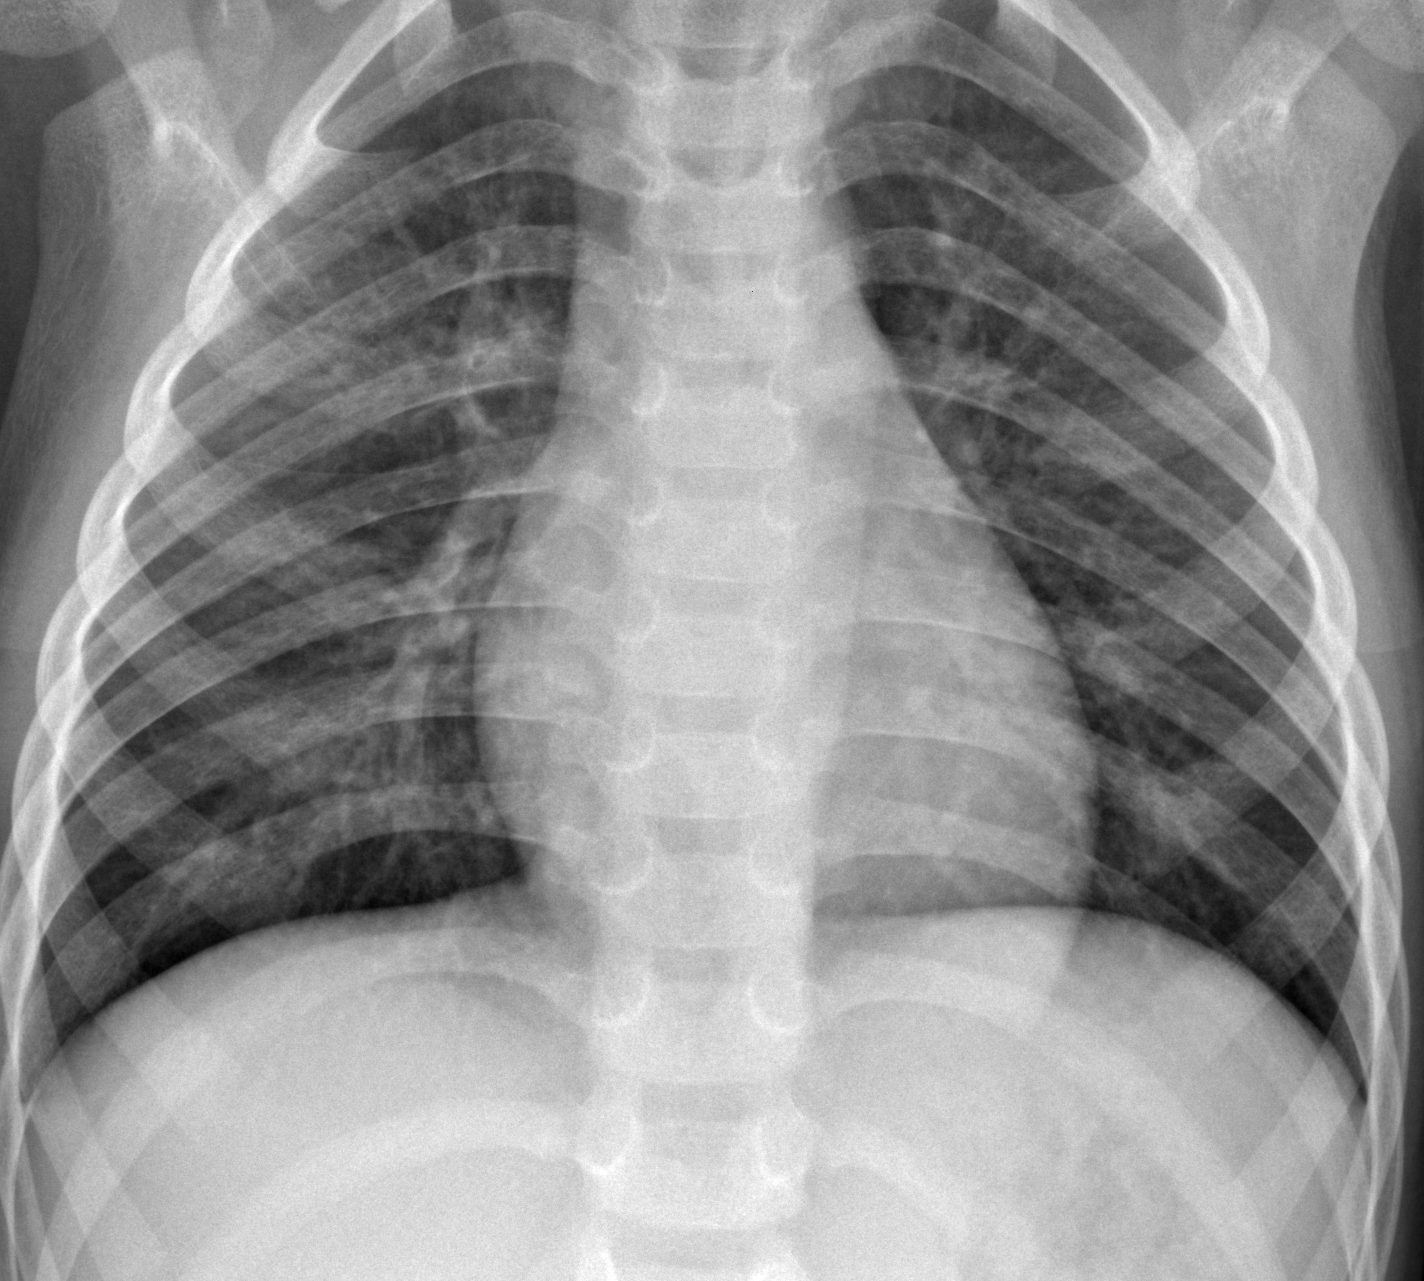

In [94]:
# Indeed, the two classes have a very similar Grayscale distribution.
# Feel free to run a Z-Test to validate.
df_['Image'][10] # As you can see, the images were cropped to display more of the lung...
# Image below is a "Normal" lung...

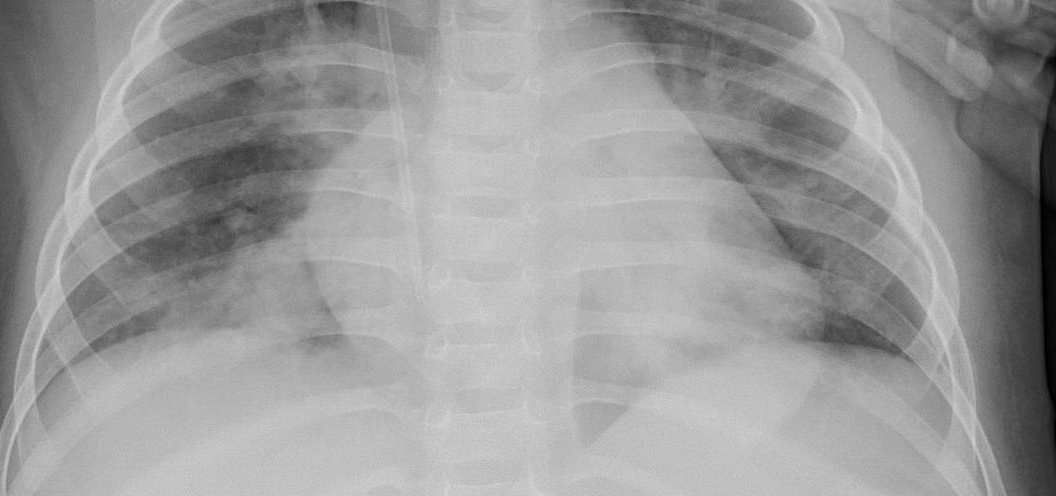

In [102]:
df_['Image'][5212] # Lung pictured below has Pneumonia...
# With the image cropped, it is now more visible (with the human eye) to
# distinguish a difference between the two lungs.

In [9]:
import numpy as np
xtrain = [np.array(image[0]) for image in formatted_images]

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [52]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [22]:
xval = []
yval = []
from PIL import Image as image
for files in os.listdir(os.chdir('D:\\SideProject\\Pnue-mondium\\chest_xray\\val')):
    if "NORAML" in files and ".jpeg" in files:
        xval.append(np.array(image.open(files)))
        yval.append(0)
    elif ".jpeg" in files and "bacteria" in files:
        xval.append(np.array(image.open(files)))
        yval.append(1)
        


In [35]:
cv2.resize(xtrain[0], (150,150))

array([[ 59,  65,  75, ..., 113, 114, 110],
       [ 59,  66,  71, ..., 115, 114, 113],
       [ 56,  63,  74, ..., 112, 115, 113],
       ...,
       [ 18,  14,  13, ...,  33,  34,  38],
       [ 22,  20,  16, ...,  56,  58,  62],
       [ 37,  32,  31, ...,  85,  89,  92]], dtype=uint8)

In [32]:
import cv2

In [63]:
# At this point, our data has been cropped and saved...
# We now convert the images to arrays..
class data:
    def __init__(self):
        self.training       = {"Normal" : None, "Pnuemonia" : None, 'Labels' : None}
        self.testing        = {"Normal" : None, "Pnuemonia" : None, 'Labels' : None}
        self.validation     = {"Normal" : None, "Pnuemonia" : None, 'Labels' : None}
    
    def get_data(self):
        import numpy as np
        import cv2
        import os
        root = "D:\\SideProject\\Pnue-mondium\\chest_xray\\"
        img_size = 150
        for split in ['train', 'test', 'val']:
            if split == 'train':
                labels = []
                pnuemonia = []
                for file in os.listdir(os.chdir(root + 'train\\formatted_training_pnuemonia')):
                    img_arr = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    pnuemonia.append(resized_arr)
                    labels.append(1)

                normal = []
                for file in os.listdir(os.chdir(root + 'train\\formatted_training_normal')):
                    img_arr = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    normal.append(resized_arr)
                    labels.append(0)
                    
                self.training['Pnuemonia'] = pnuemonia
                self.training['Normal'] = normal
                self.training["Labels"] = labels
            elif split == 'test':
                pnuemonia = []
                labels = []
                for file in os.listdir(os.chdir(root + 'test\\formatted_test_pnuemonia')):
                    img_arr = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    pnuemonia.append(resized_arr)
                    labels.append(1)
                
                
                normal = []
                for file in os.listdir(os.chdir(root + 'test\\formatted_test_normal')):
                    img_arr = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    normal.append(resized_arr)
                    labels.append(0)
                    
                self.testing['Pnuemonia'] = pnuemonia
                self.testing['Normal'] = normal   
                self.testing['Labels'] = labels
            else:
                pnuemonia = []
                labels = []
                for file in os.listdir(os.chdir(root + 'val\\formatted_val_pnuemonia')):
                    img_arr = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    pnuemonia.append(resized_arr)
                    labels.append(1)
                
                
                normal = []
                for file in os.listdir(os.chdir(root + 'val\\formatted_val_normal')):
                    img_arr = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    normal.append(resized_arr)
                    labels.append(0)
                    
                self.validation['Pnuemonia'] = pnuemonia
                self.validation['Normal'] = normal  
                self.validation["Labels"] = labels
        
        
data_ = data()
data_.get_data()

In [66]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(xTrain)

In [65]:
xTrain = (np.array(data_.training['Pnuemonia'] + data_.training['Normal']) / 255).reshape(-1, 150, 150, 1)
yTrain = np.array(data_.training['Labels'])
xTest = (np.array(data_.testing['Pnuemonia'] + data_.testing['Normal']) / 255).reshape(-1, 150, 150, 1)
yTest = np.array(data_.testing['Labels'])
xVal = (np.array(data_.validation['Pnuemonia'] + data_.validation['Normal']) / 255).reshape(-1, 150, 150, 1)
yVal = np.array(data_.validation['Labels'])

In [71]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(xTrain, yTrain, batch_size = 32), epochs = 12 , validation_data = datagen.flow(xVal, yVal) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 238s 1s/step - loss: 0.5690 - accuracy: 0.8401 - val_loss: 34.3818 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 254s 2s/step - loss: 0.2806 - accuracy: 0.8928 - val_loss: 37.8106 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.9089
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 269s 2s/step - loss: 0.2478 - accuracy: 0.9089 - val_loss: 42.1919 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 255s 2s/step - loss: 0.1683 - accuracy: 0.9390 - val_loss: 0.7770 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 254s 2s/step - loss: 0.1610 - accuracy: 0.9433 - val_loss: 2.6554 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/12
163/163 [========================

In [72]:
print("Loss of the model is - " , model.evaluate(xTest,yTest)[0])
print("Accuracy of the model is - " , model.evaluate(xTest,yTest)[1]*100 , "%")

20/20 [==============================] - 5s 248ms/step - loss: 0.3145 - accuracy: 0.8958
Loss of the model is -  0.3144628703594208
20/20 [==============================] - 5s 248ms/step - loss: 0.3145 - accuracy: 0.8958
Accuracy of the model is -  89.58333134651184 %


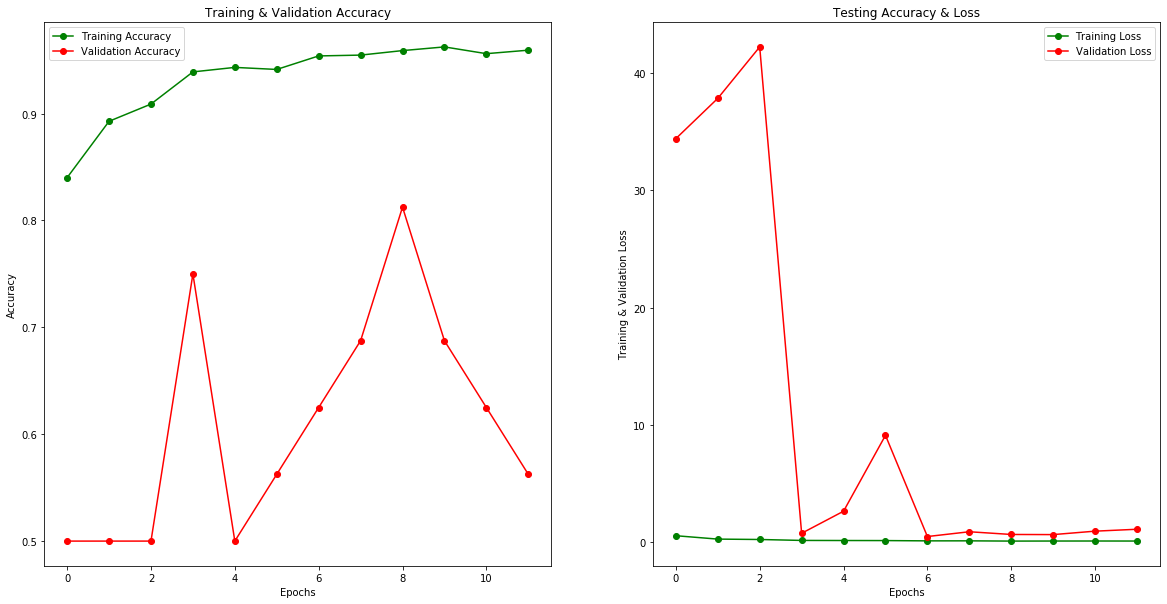

In [73]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()


In [77]:
predictions = model.predict_classes(xTest)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [79]:
print(classification_report(yTest, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.79      0.85       234
   Normal (Class 1)       0.88      0.96      0.92       390

           accuracy                           0.90       624
          macro avg       0.90      0.87      0.89       624
       weighted avg       0.90      0.90      0.89       624



In [80]:
cm = confusion_matrix(yTest,predictions)
cm

array([[185,  49],
       [ 16, 374]], dtype=int64)

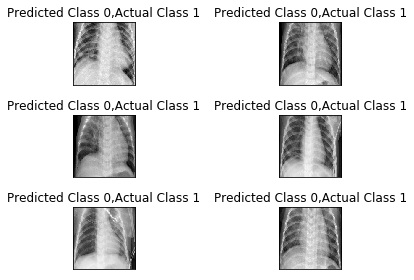

In [82]:
correct = np.nonzero(predictions == yTest)[0]
incorrect = np.nonzero(predictions != yTest)[0]
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(xTest[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], yTest[c]))
    plt.tight_layout()
    i += 1